In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import warnings

sns.set(font_scale=1.3, 
        font='Calibri', 
        style="whitegrid")

## Carregando os dados

### Dados sobre os estudates

In [3]:
df_students = pd.read_json('data/BASE B/students.json')
df_students['RegisteredDate'] = pd.to_datetime(df_students['RegisteredDate'])
df_students.head()

,Id,RegisteredDate,UniversityName,CourseName,State,SignupSource,City,StudentClient
0,12970655,2012-05-29 15:22:27.490,PUC-RIO,Administração,Rio de Janeiro,Email,NaN,NaN
1,59873654,2012-09-03 20:32:04.853,UFF,Direito do Trabalho e Segurança Social,Rio de Janeiro,Facebook,Rio de Janeiro,NaN
2,3664695,2012-09-10 20:26:30.253,UNB,Enfermagem,Distrito Federal,Facebook,NaN,NaN
3,15207697,2012-09-05 15:31:08.090,UERJ,Engenharia de Produção Mecânica,Rio de Janeiro,Facebook,Resende,NaN
4,36988693,2012-10-15 21:34:51.143,UFU,Engenharia Elétrica,NaN,Facebook,NaN,NaN


### Dados sobre os cancelamentos

In [4]:
df_cancellations = pd.read_json('data/BASE B/premium_cancellations.json')
df_cancellations['CancellationDate'] = pd.to_datetime(df_cancellations['CancellationDate'])
df_cancellations['year'] = df_cancellations['CancellationDate'].dt.year
df_cancellations['month'] = df_cancellations['CancellationDate'].dt.month
df_cancellations.head()

,StudentId,CancellationDate,year,month
0,34129668,2016-05-05 19:08:31.937,2016,5
1,34129668,2016-05-05 22:48:20.830,2016,5
2,82394932,2016-05-20 22:37:21.117,2016,5
3,82942835,2016-05-31 13:44:55.307,2016,5
4,85382416,2016-06-01 14:22:19.467,2016,6


### Dados sobre as assinaturas do plano Premium

In [5]:
df_payments = pd.read_json('data/BASE B/premium_payments.json').sort_values('PaymentDate')
df_payments['PaymentDate'] = pd.to_datetime(df_payments['PaymentDate'])

df_payments['PlanDuration'] = pd.DateOffset(months=1)
df_payments.loc[df_payments['PlanType'] == 'Anual', 'PlanDuration'] = pd.DateOffset(years=1)

df_payments['ExpiryDate'] = df_payments['PaymentDate'] + df_payments['PlanDuration']

df_payments['year'] = df_payments.PaymentDate.dt.year
df_payments['month'] = df_payments.PaymentDate.dt.month
df_payments['year-month'] = df_payments['year'].astype(str) + '-' + df_payments['month'].astype(str)

df_payments.head()

/home/lucas/miniconda3/envs/pdenv/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py:1151: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  PerformanceWarning,


,StudentId,PaymentDate,PlanType,PlanDuration,ExpiryDate,year,month,year-month
1902,78584527,2015-08-08 00:00:00.000,Mensal,<DateOffset: months=1>,2015-09-08 00:00:00.000,2015,8,2015-8
956,55313801,2015-08-19 00:00:00.000,Mensal,<DateOffset: months=1>,2015-09-19 00:00:00.000,2015,8,2015-8
565,96396664,2015-08-23 00:00:00.000,Mensal,<DateOffset: months=1>,2015-09-23 00:00:00.000,2015,8,2015-8
1888,27891872,2015-09-06 20:05:51.157,Mensal,<DateOffset: months=1>,2015-10-06 20:05:51.157,2015,9,2015-9
176,5523173,2015-09-12 16:00:31.940,Mensal,<DateOffset: months=1>,2015-10-12 16:00:31.940,2015,9,2015-9


### Dados sobre as sessões

In [6]:
df_sessions = pd.read_json('data/BASE B/sessions.json')
df_sessions['SessionStartTime'] = pd.to_datetime(df_sessions['SessionStartTime'])
df_sessions.sort_values('SessionStartTime', inplace=True)

df_sessions['year'] = df_sessions.SessionStartTime.dt.year
df_sessions['month'] = df_sessions.SessionStartTime.dt.month
df_sessions['year-month'] = df_sessions['year'].astype(str) + '-' + df_sessions['month'].astype(str)

df_sessions['day'] = df_sessions.SessionStartTime.dt.day
df_sessions['hour'] = df_sessions.SessionStartTime.dt.hour

df_sessions['weekday'] = df_sessions.SessionStartTime.dt.weekday
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_sessions['weekday'] = df_sessions['weekday'].map(lambda x: weekdays[x])

df_sessions.head()

,StudentId,SessionStartTime,StudentClient,year,month,year-month,day,hour,weekday
205146,82394932,2017-02-07 17:46:00,Website,2017,2,2017-2,7,17,Tuesday
205147,82394932,2017-02-07 17:53:33,Website,2017,2,2017-2,7,17,Tuesday
615932,32938466,2017-02-08 11:42:47,Website,2017,2,2017-2,8,11,Wednesday
4326,59828530,2017-02-08 11:46:22,Website,2017,2,2017-2,8,11,Wednesday
87112,51668081,2017-02-08 11:48:08,Website,2017,2,2017-2,8,11,Wednesday


# Área Cliente
## Alunos por curso

In [7]:
df_students.groupby('CourseName')['Id'].count().sort_values(ascending=False).head(20)

CourseName
Direito                               9862
Administração                         4099
Engenharia Civil                      3585
Contabilidade / Ciências Contábeis    2744
Pedagogia                             2627
Psicologia                            2155
Enfermagem                            2054
Medicina                              1656
Fisioterapia                          1464
Engenharia Mecânica                   1451
Nutrição                              1297
Farmácia / Ciências Farmacêuticas     1142
Educação Física                       1076
Engenharia de Produção                1053
Odontologia                            985
Engenharia Elétrica                    957
Veterinária / Medicina Veterinária     890
Biologia / Ciências Biológicas         753
Arquitetura e Urbanismo                724
Gestão de Recursos Humanos             645
Name: Id, dtype: int64

### Acessos por plataforma

Text(0.5, 0, 'Platform of access')

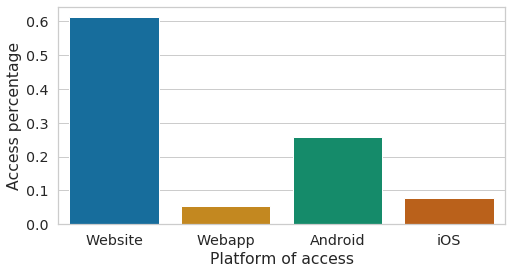

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
access_per_client = df_sessions.groupby('StudentClient', sort=False)['SessionStartTime'].count() / len(df_sessions)
sns.barplot(x='StudentClient', y='SessionStartTime', 
            data=access_per_client.reset_index(),
            palette='colorblind', ax=ax)
ax.set_ylabel('Access percentage')
ax.set_xlabel('Platform of access')

# Área Financeira
### Quantidade de assinantes Premium

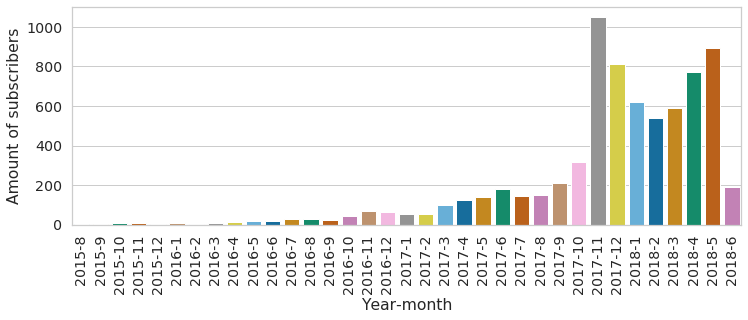

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.barplot(x='year-month', y='PaymentDate', 
            data=df_payments.groupby('year-month', sort=False).count()['PaymentDate'].reset_index(),
            palette='colorblind', ax=ax)
ax.set_ylabel('Amount of subscribers')
ax.set_xlabel('Year-month')
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Análise de renovações de plano anual
#### Usuários cujo primeiro plano anual já expirou

In [19]:
first_anual_expiry = df_payments.query('PlanType == "Anual"').groupby('StudentId')['ExpiryDate'].min()
first_anual_expiry_users = first_anual_expiry[first_anual_expiry < df_payments['PaymentDate'].max()].index

#### Quantidade de usuáios que assinaram o plano anual $n$ vezes
Mais de 50% de taxa de renovação.

In [28]:
annual_payments = df_payments.query('StudentId in @first_anual_expiry_users')\
                             .groupby(['PlanType', 'StudentId'])['PaymentDate']\
                             .count().loc['Anual'].value_counts()
display(annual_payments)
annual_payments[annual_payments.index > 1].sum() / annual_payments.sum()

1    31
2    30
3     3
Name: PaymentDate, dtype: int64

0.515625

#### Percentual de usuários Premium que optam pelo plano anual

In [29]:
len(df_payments.query('PlanType == "Anual"').StudentId.unique()) / len(df_payments.StudentId.unique())

0.14624306606152296

# Área Marketing
### Acessos ao longo da semana

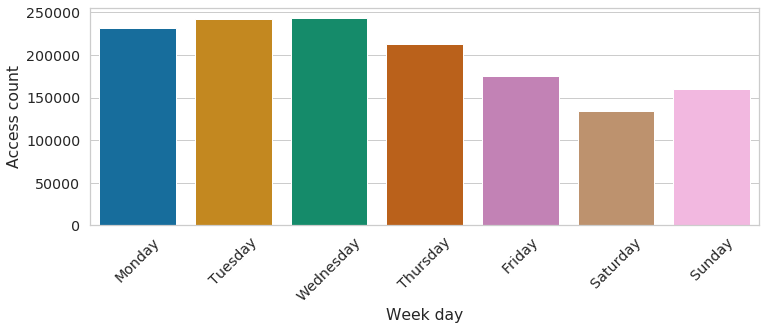

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.barplot(x='weekday', y='SessionStartTime', 
            data=df_sessions.groupby('weekday')['SessionStartTime'].count()[weekdays].reset_index(),
            palette='colorblind', ax=ax)
ax.set_ylabel('Access count')
ax.set_xlabel('Week day')
ticks = ax.set_xticklabels(weekdays, rotation=45)

### Acessos por mês

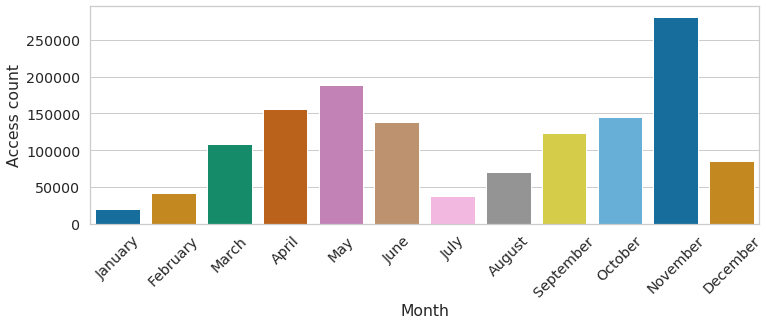

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.barplot(x='month', y='SessionStartTime', 
            data=df_sessions.groupby('month')['SessionStartTime'].count().reset_index(),
            palette='colorblind', ax=ax)
ax.set_ylabel('Access count')
ax.set_xlabel('Month')
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
          'August', 'September', 'October', 'November', 'December']
ticks = ax.set_xticklabels(months, rotation=45)

### Acessos ao longo dos meses

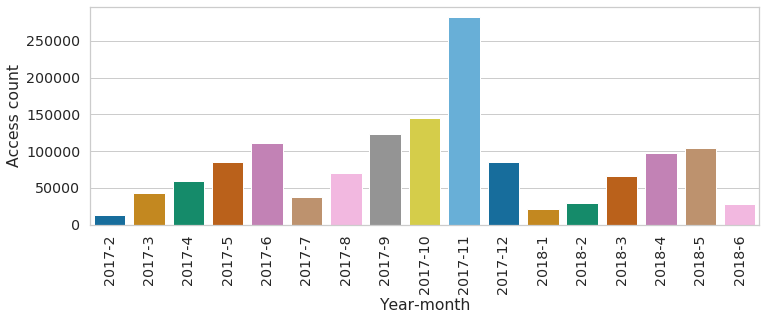

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.barplot(x='year-month', y='SessionStartTime', 
            data=df_sessions.groupby('year-month', sort=False)['SessionStartTime'].count().reset_index(),
            palette='colorblind', ax=ax)
ax.set_ylabel('Access count')
ax.set_xlabel('Year-month')
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')

### Acessos por hora do dia

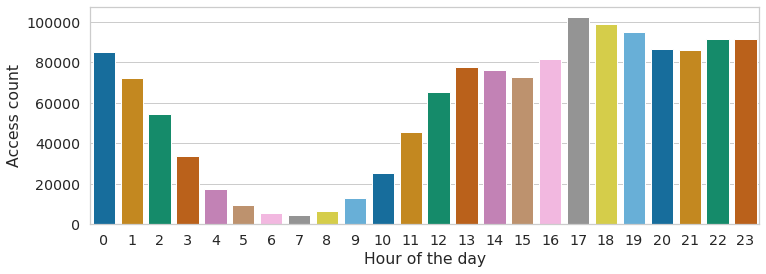

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.barplot(x='hour', y='SessionStartTime', 
            data=df_sessions.groupby('hour', sort=False)['SessionStartTime'].count().reset_index(),
            palette='colorblind', ax=ax)
ax.set_ylabel('Access count')
ax.set_xlabel('Hour of the day')